In [1]:
import numpy as np
from scipy.stats import sem as SEM
from scipy.stats import ttest_rel, ttest_ind
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import sns_styleset
%matplotlib inline

In [2]:
sns_styleset()

### Functions to run the test

In [3]:
def get_ts(corrmat,group,intra_label):
    '''Run a two-sided 2-sample t-test between intra-group and inter-group'''
    
    intra_idx = group==intra_label
    inter_idx = group!=intra_label
    #use only the columns of the intra group
    corr_with_reference = corrmat[:,intra_idx]
    #take means across rows such that each mean is of an independent ROI
    intra_cell_means = np.nanmean(corr_with_reference[intra_idx,:],axis=1)
    inter_cell_means = np.nanmean(corr_with_reference[inter_idx,:],axis=1)

    t,_ = ttest_ind(intra_cell_means,inter_cell_means)
    
    return np.abs(t)

def get_ts_paired(corrmat,group,intra_label):
    '''Run a two-sided paired t-test between intra-group and inter-group'''
    
    intra_idx = group==intra_label
    inter_idx = group!=intra_label    
    #use only the rows of the intra group
    corr_with_reference = corrmat[intra_idx,:]
    #within those rows, take means across the inter- and the intra columns, resulting in two paired means per ROI
    intra_corr_means = np.nanmean(corr_with_reference[:,intra_idx],axis=1)
    inter_corr_means = np.nanmean(corr_with_reference[:,inter_idx],axis=1)

    t,_ = ttest_rel(intra_corr_means,inter_corr_means)
    
    return np.abs(t)
    
def get_ts_intra(corrmat,group,label_g1,label_g2):
    '''Run a two-sided 2-sample t-test between the with-group correlations of two groups'''
    
    g1_idx = group==label_g1
    g2_idx = group==label_g2
    
    g1_corr = corrmat[:,g1_idx][g1_idx,:]
    g2_corr = corrmat[:,g2_idx][g2_idx,:]

    g1_cell_means = np.nanmean(g1_corr,axis=1)
    g2_cell_means = np.nanmean(g2_corr,axis=1)

    t,_ = ttest_ind(g1_cell_means,g2_cell_means)
    
    return np.abs(t)

def get_p_perm(ts_perm, t_emp):
    '''calculate p-value from the observed t-value and the permutation t-values'''
    #note that all ts are absolute values already
    n_ts_more_extreme = np.sum(ts_perm>t_emp)
    return n_ts_more_extreme/len(ts_perm)
           
def permutation_test(corrmat,group,intra_label=1,n_permutations=1000,seed=0,paired=False):
    '''
        Run a permutation test on the `get_ts()` t-statistic by permuting the group labels of the ROIs.
        Compares a ROI-type's within-type correlation to its between-type correlations with another type.
        Assumes `corrmat` and `group` is already subset to the two ROI types involved.
    '''
    corrmat = corrmat.copy()
    np.fill_diagonal(corrmat,np.nan)
    
    #get empirical ts
    
    
    if paired:
        t_emp = get_ts_paired(corrmat,group,intra_label)
    else:
        t_emp = get_ts(corrmat,group,intra_label)
    
    #permute
    ts=[]
    np.random.seed(seed)
    for i in range(n_permutations):
        if np.mod(i,1000)==0:
            print('.',end='')
        rois_perm_idx = np.random.permutation(len(corrmat))
        corrmat_permuted = corrmat[:,rois_perm_idx][rois_perm_idx,:]
        if paired:
            t = get_ts_paired(corrmat_permuted,group,intra_label)
        else:
            t = get_ts(corrmat_permuted,group,intra_label)
        ts.append(t)

    
    
    #get permutation-based p value
    p = get_p_perm(ts, t_emp)
    
    return t_emp, ts, p   

def permutation_test_intra(corrmat,group,label_g1=1,label_g2=2,n_permutations=1000,seed=0):
    '''
        Run a permutation test on the `get_ts_intra()` t-statistic by permuting the group labels of the ROIs.
        Compares two ROI-types' within-group correlations.
        Assumes `corrmat` and `group` is already subset to the two ROI types involved.
     '''

    corrmat = corrmat.copy()
    np.fill_diagonal(corrmat,np.nan)
    
    #get empirical t
    t_emp = get_ts_intra(corrmat,group,label_g1,label_g2)
    
    #permute
    ts=[]
    np.random.seed(seed)
    for i in range(n_permutations):
        if np.mod(i,1000)==0:
            print('.',end='')

        rois_perm_idx = np.random.permutation(len(corrmat))
        corrmat_permuted = corrmat[:,rois_perm_idx][rois_perm_idx,:]
        t = get_ts_intra(corrmat_permuted,group,label_g1,label_g2)
        ts.append(t)
        
    #get permutation-based p value
    p = get_p_perm(ts, t_emp)
    
    return (t_emp, ts, p)

#### Load data

In [4]:
#tips
tips = np.loadtxt('./data/Traces_OPL0_t_withoutQithres.txt',delimiter=',')
tips = tips[66:302,:].T
print('Tips: ', tips.shape)
#bulbs
bulbs = np.loadtxt('./data/Traces_OPL0_b_withoutQithres.txt',delimiter=',')
bulbs = bulbs[65:301,:].T
print('Bulbs: ', bulbs.shape)
#somata
somata = np.loadtxt('./data/Traces_OPL0_s_withoutQithres.txt',delimiter=',')
somata = somata[65:301,:].T
print('Somata: ', somata.shape)

Tips:  (104, 236)
Bulbs:  (181, 236)
Somata:  (80, 236)


In [5]:
#combine traces and get correlations
traces_all = np.concatenate((somata,bulbs,tips))
corrmat_all = np.corrcoef(traces_all)

#setup indicator variables
groups_all = np.array(['soma'] * len(somata) + ['bulb'] * len(bulbs) + ['tip'] * len(tips) )
group_names,group_idx = np.unique(groups_all,return_inverse=True)

In [6]:
def run_inter_tests():
    '''Runs and plots all within-type-vs-between-types permutation tests.'''
    #iterate over combination of groups
    for intra_group in group_names[np.array([1,0,2])]:
        for inter_group in group_names:
            if intra_group==inter_group:
                continue

            plt.figure(figsize=(10,5))

            #compute indices to correlation matrix
            include_idx = np.isin(groups_all,[inter_group,intra_group])
            intra_idx = np.isin(groups_all,[intra_group])
            inter_idx = np.isin(groups_all,[inter_group])

            #subset correlation matrix and group indicator to only the two groups to compare
            corrmat = corrmat_all[include_idx,:][:,include_idx]
            groups = groups_all[include_idx]

            #perform permutation test
            t_emp, ts, p_perm = permutation_test(corrmat, groups, intra_label=intra_group, n_permutations=1000)
            
            
            means_emp_intra = np.nanmean(corrmat_all[:,intra_idx][intra_idx,:],axis=1)
            means_emp_inter = np.nanmean(corrmat_all[:,intra_idx][inter_idx,:],axis=1)

            #histogram preperations
            ts_concat = np.concatenate([ts,np.array([t_emp])])
            bins=np.linspace(min(ts_concat),max(ts_concat),num=50)

            plt.subplot(121)       
            plt.title('permutation test') 
            #plot permutation test histogram (t-values from permutations)
            histcounts,_,_ = plt.hist(ts,bins=bins,alpha=0.3,label='permutation t-values',color='tab:orange')
            histcounts_max = max((histcounts))
            #observed t-values
            plt.vlines(t_emp,0,histcounts_max,colors='tab:orange',label='observed t-value')
            plt.legend(loc=(0.35,0.4))
            #p-values
            plt.text(0.5,0.7,r'$p=%.4f$'%(p_perm),transform=plt.gca().transAxes,color='tab:orange')
            plt.text(0.5,0.6,r'max $t_{permuted}=%.2f$'%(max(ts)),transform=plt.gca().transAxes,color='tab:orange')



            plt.subplot(122)
            plt.title('observed mean correlations') 
            #intra vs. inter correlations
            cell_means = np.concatenate((means_emp_intra,
                                         means_emp_inter))
            label = np.array(['%s-%s'%(intra_group,intra_group)] * sum(intra_idx) + 
                             ['%s-%s'%(intra_group,inter_group)] * sum(inter_idx)) 
            sns.pointplot(x=label,y=cell_means,color='tab:orange',join=False)
            sns.swarmplot(x=label,y=cell_means,color='tab:orange',alpha=0.3)
            plt.xlabel('group')
            plt.ylabel('mean correlation\nacross references')

                
            plt.suptitle('INTER vs INTRA: \n%s-%s vs. %s-%s'% (intra_group,inter_group,intra_group,intra_group))
            sns.despine()
            
            plt.tight_layout()

In [7]:
def run_reverse_inter_tests():
    '''Runs and plots all within-type-vs-between-types permutation tests.'''
    #iterate over combination of groups
    for intra_group in group_names[np.array([1,0,2])]:
        for inter_group in group_names:
            if intra_group==inter_group:
                continue

            plt.figure(figsize=(15,5))

            #compute indices to correlation matrix
            include_idx = np.isin(groups_all,[inter_group,intra_group])
            intra_idx = np.isin(groups_all,[intra_group])
            inter_idx = np.isin(groups_all,[inter_group])

            #subset correlation matrix and group indicator to only the two groups to compare
            corrmat = corrmat_all[include_idx,:][:,include_idx]
            groups = groups_all[include_idx]

            #perform PAIRED permutation test
            t_emp, ts, p_perm = permutation_test(corrmat, groups, intra_label=intra_group, n_permutations=1000,paired=True)
            
            #calculate PAIRED means
            means_emp_intra = np.nanmean(corrmat_all[intra_idx,:][:,intra_idx],axis=1)
            means_emp_inter = np.nanmean(corrmat_all[intra_idx,:][:,inter_idx],axis=1)

            #histogram preperations
            ts_concat = np.concatenate([ts,np.array([t_emp])])
            bins=np.linspace(min(ts_concat),max(ts_concat),num=50)

            plt.subplot(131)       
            plt.title('permutation test') 
            #plot permutation test histogram (t-values from permutations)
            histcounts,_,_ = plt.hist(ts,bins=bins,alpha=0.3,label='permutation t-values',color='tab:blue')
            histcounts_max = max((histcounts))
            #observed t-values
            plt.vlines(t_emp,0,histcounts_max,colors='tab:blue',label='observed t-value')
            plt.legend(loc=(0.35,0.4))
            #p-values
            plt.text(0.5,0.7,r'$p=%.4f$'%(p_perm),transform=plt.gca().transAxes,color='tab:blue')
            plt.text(0.5,0.6,r'max $t_{permuted}=%.2f$'%(max(ts)),transform=plt.gca().transAxes,color='tab:blue')



            plt.subplot(132)
            plt.title('observed mean correlations') 
            #intra vs. inter correlations
            cell_means = np.concatenate((means_emp_intra,
                                         means_emp_inter))
            label = np.array(['%s-%s'%(intra_group,intra_group)] * sum(intra_idx) + 
                             ['%s-%s'%(inter_group,intra_group)] * sum(intra_idx)) 
            sns.pointplot(x=label,y=cell_means,color='tab:blue',join=False)
            sns.swarmplot(x=label,y=cell_means,color='tab:blue',alpha=0.3)
            plt.xlabel('group')
            plt.ylabel('mean correlation\nacross references')
            
            plt.subplot(133)
            plt.hist(means_emp_intra-means_emp_inter,bins=12,alpha=0.3)
            plt.xlabel('intra-inter difference')
            plt.title('paired differences')
                
            plt.suptitle('INTER vs INTRA -- reversed/paired: \n%s-%s vs. %s-%s'% (inter_group,intra_group,intra_group,intra_group))
            sns.despine()
            
            plt.tight_layout()

In [8]:
def run_intra_tests():
    '''Runs and plots all within-type-vs-within-type permutation tests.'''
    #iterate over combination of groups
    for intra_g1_i in range(len(group_names)):
        for intra_g2_i in range(len(group_names)):

            if intra_g1_i>=intra_g2_i:
                continue

            plt.figure(figsize=(10,5))

            intra_g1_label = group_names[intra_g1_i]
            intra_g2_label = group_names[intra_g2_i]


            #compute indices to correlation matrix
            include_idx = np.isin(groups_all,[intra_g1_label,intra_g2_label])
            g1_idx = np.isin(groups_all,[intra_g1_label])
            g2_idx = np.isin(groups_all,[intra_g2_label])

            #subset correlation matrix and group indicator to only the two groups to compare
            corrmat = corrmat_all[include_idx,:][:,include_idx]
            groups = groups_all[include_idx]

            #perform permutation test
            t_emp, ts, p_perm = permutation_test_intra(corrmat,groups,intra_g1_label,intra_g2_label,n_permutations=1000)
            
            means_emp_g1 = np.nanmean(corrmat_all[:,g1_idx][g1_idx,:],axis=1)
            means_emp_g2 = np.nanmean(corrmat_all[:,g2_idx][g2_idx,:],axis=1)

            #histogram preperations
            ts_concat = np.append(ts,t_emp)
            bins=np.linspace(min(ts_concat),max(ts_concat),num=50)

            plt.subplot(121)       
            plt.title('permutation test') 
            #plot permutation test histogram (t-values from permutations)
            histcounts,_,_ = plt.hist(ts,bins=bins,alpha=0.3,label='permutation t-values',color='tab:green')
            histcounts_max = max(histcounts)
            #observed t-values
            plt.vlines(t_emp,0,histcounts_max,colors='tab:green',label='observed t-value')
            plt.legend(loc=(0.35,0.4))
            #p-values
            plt.text(0.5,0.7,r'$p_{intra}=%.4f$'%(p_perm),transform=plt.gca().transAxes,color='tab:green')
            plt.text(0.5,0.6,r'max $t_{permuted}=%.2f$'%(max(ts)),transform=plt.gca().transAxes,color='tab:green')



            plt.subplot(122)
            plt.title('observed mean correlations') 
            #intra vs. intra correlations
            cell_means = np.concatenate((means_emp_g1,
                                         means_emp_g2))
            label = np.array(['%s-%s'%(intra_g1_label,intra_g1_label)] * sum(g1_idx) + 
                             ['%s-%s'%(intra_g2_label,intra_g2_label)] * sum(g2_idx)) 
            sns.pointplot(x=label,y=cell_means,color='tab:green',join=False)
            sns.swarmplot(x=label,y=cell_means,color='tab:green',alpha=0.3)

            
            plt.xlabel('group')
            plt.ylabel('mean correlation\nacross references')



            plt.suptitle('INTRA vs INTRA:\n%s-%s vs. %s-%s' % (intra_g1_label,intra_g1_label,intra_g2_label,intra_g2_label)) 
            sns.despine()
            plt.tight_layout()


...............

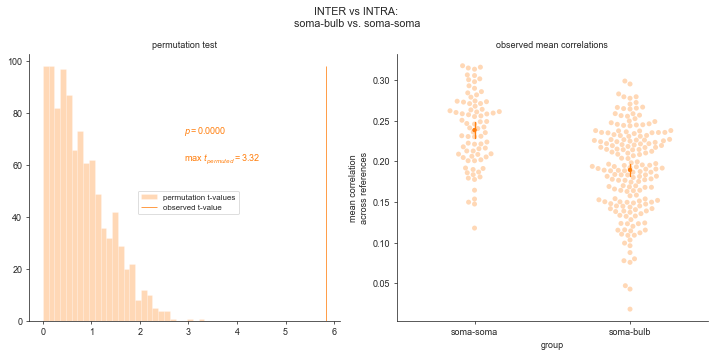

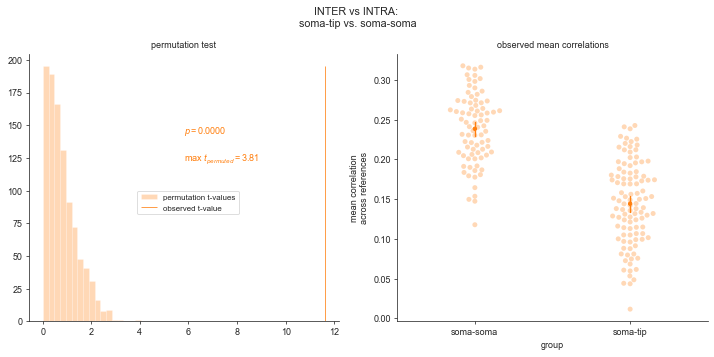

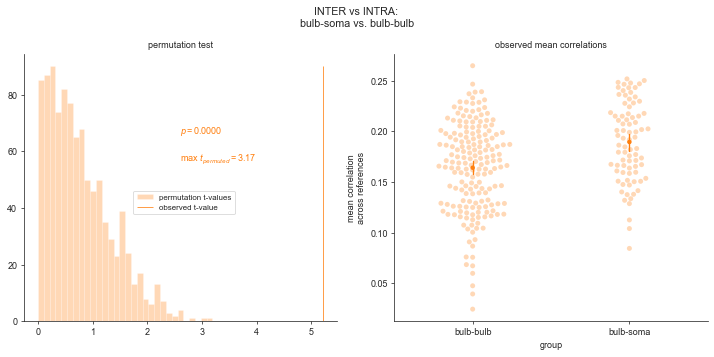

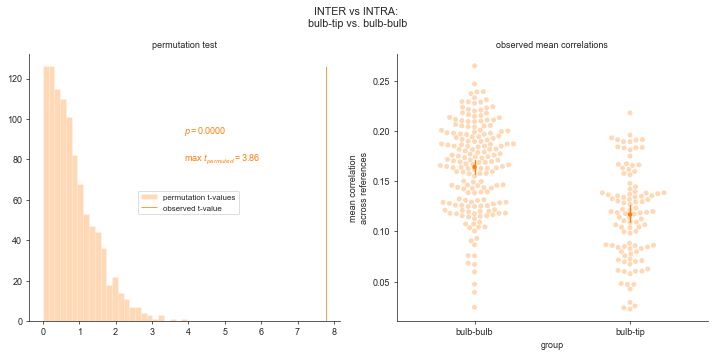

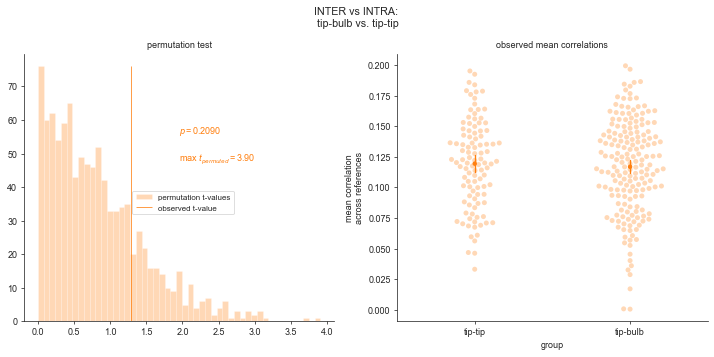

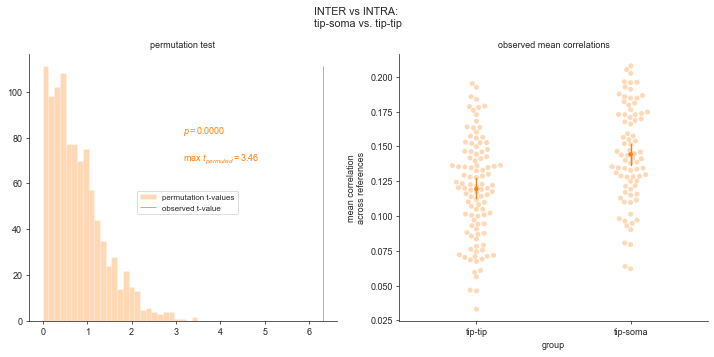

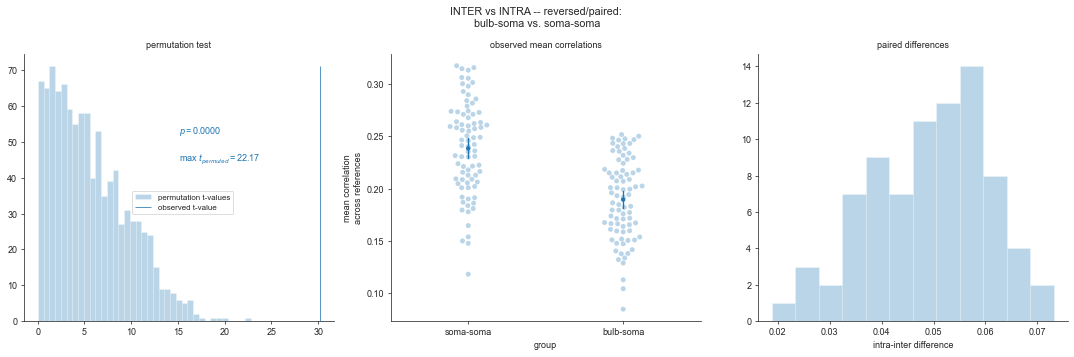

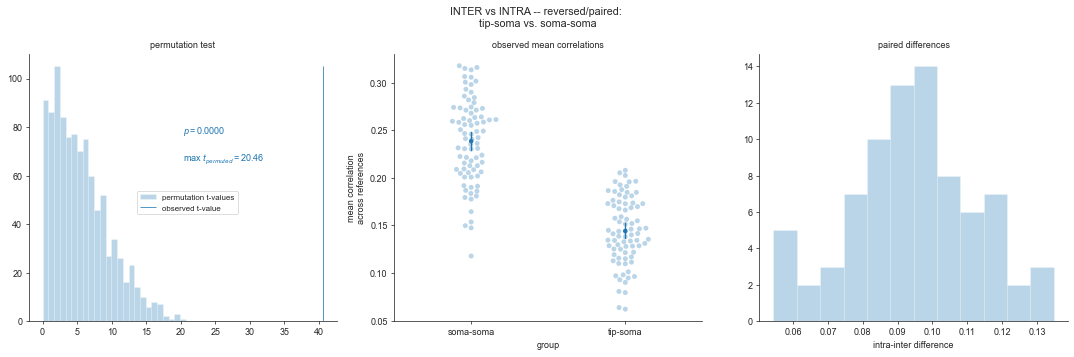

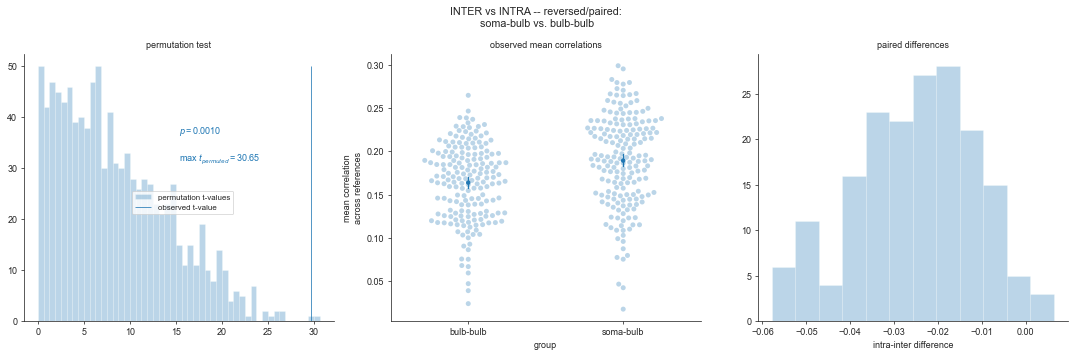

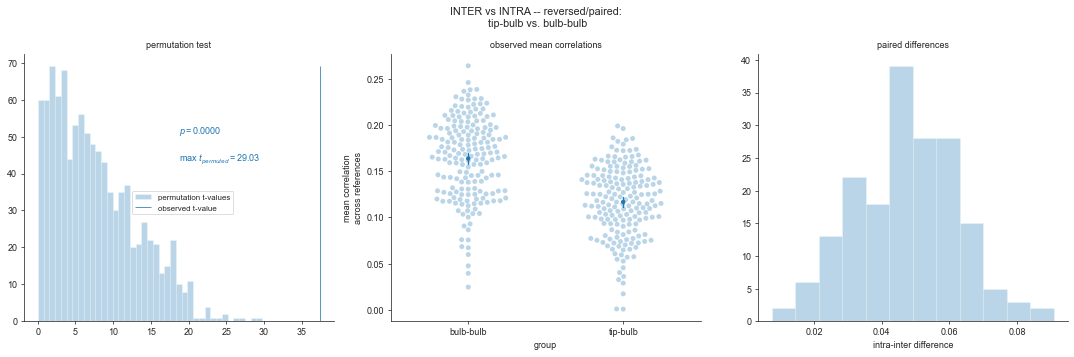

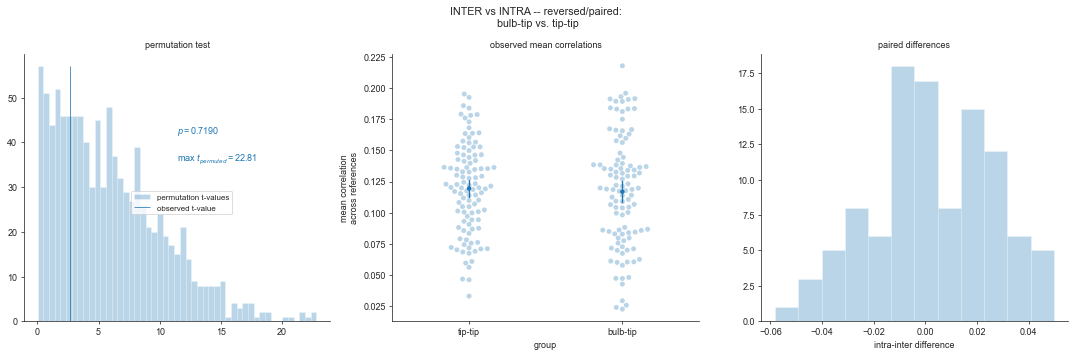

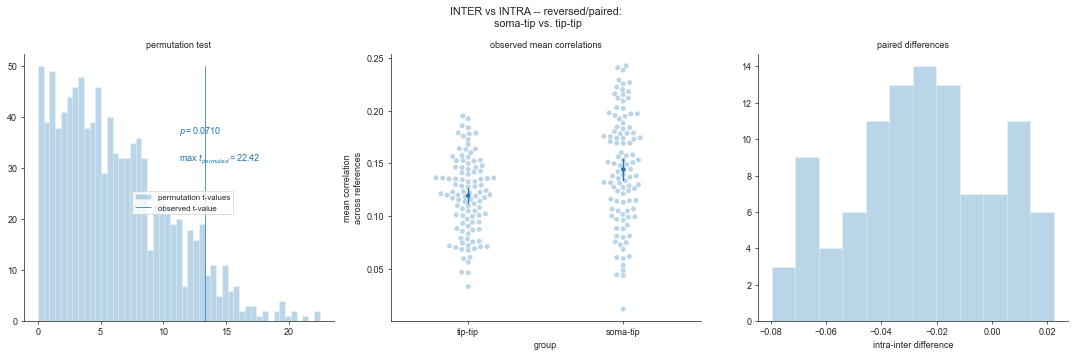

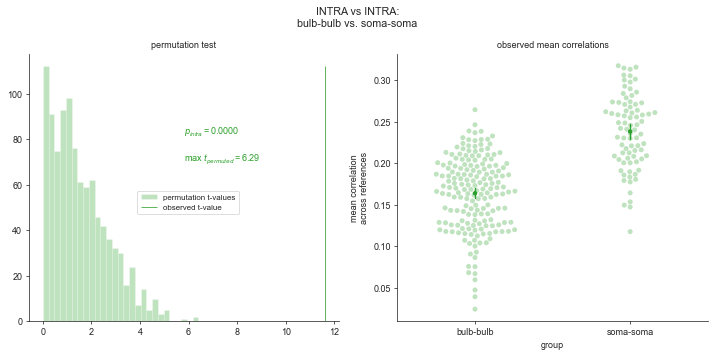

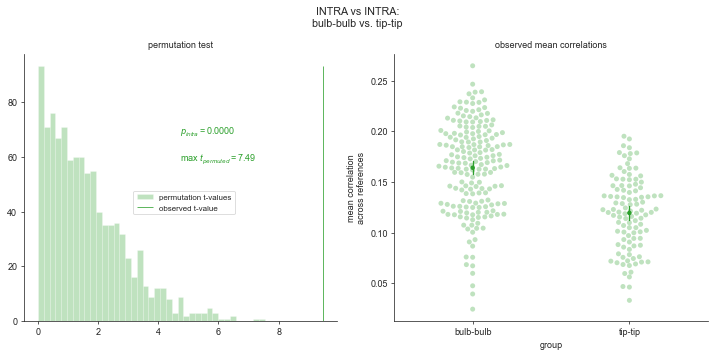

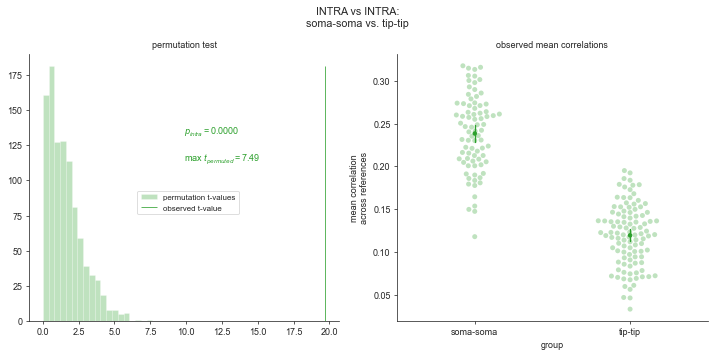

In [9]:
run_inter_tests()
run_reverse_inter_tests()
run_intra_tests()

In [10]:
def get_emp_means():
    '''computes the observed mean correlations per ROI that are tested for significance with the permutation tests'''
    means = []
    labels = []
    #iterate over combination of groups
    for intra_group in group_names[np.array([1,0,2])]:
        occurance_intra_group=0
        for inter_group in group_names:
            
            if intra_group==inter_group:
                continue
            print(intra_group,inter_group)
            
            #compute indices to correlation matrix
            include_idx = np.isin(groups_all,[inter_group,intra_group])
            intra_idx = np.isin(groups_all,[intra_group])
            inter_idx = np.isin(groups_all,[inter_group])

            #subset correlation matrix and group indicator two only the two groups to compare
            corrmat = corrmat_all[include_idx,:][:,include_idx]
            groups = groups_all[include_idx]

            means_emp_intra = np.nanmean(corrmat_all[:,intra_idx][intra_idx,:],axis=1)
            means_emp_inter = np.nanmean(corrmat_all[:,intra_idx][inter_idx,:],axis=1)

            cell_means = np.concatenate((means_emp_intra,
                                         means_emp_inter))
            label = np.array(['%s-%s'%(intra_group,intra_group)] * sum(intra_idx) + 
                             ['%s-%s'%(intra_group,inter_group)] * sum(inter_idx)) 

            if occurance_intra_group==0:
                means.append(cell_means)
                labels.append(label)
            else:
                means.append(means_emp_inter) #if we already added the intra correlations once, only append inter means
                labels.append(label[-sum(inter_idx):]) #also only append inter labels
            
            occurance_intra_group +=1
            
    return means,labels

In [11]:
means,labels = get_emp_means()

soma bulb
soma tip
bulb soma
bulb tip
tip bulb
tip soma


           CONDITION   MEAN +- 95%CI
Text(0, 0, 'tip-soma') 0.144 0.137 0.152
Text(1, 0, 'tip-tip') 0.119 0.112 0.126
Text(2, 0, 'tip-bulb') 0.117 0.111 0.123
Text(3, 0, 'bulb-tip') 0.117 0.109 0.125
Text(4, 0, 'bulb-bulb') 0.164 0.157 0.17
Text(5, 0, 'bulb-soma') 0.189 0.181 0.198
Text(6, 0, 'soma-bulb') 0.189 0.182 0.197
Text(7, 0, 'soma-soma') 0.239 0.229 0.249
Text(8, 0, 'soma-tip') 0.144 0.134 0.155


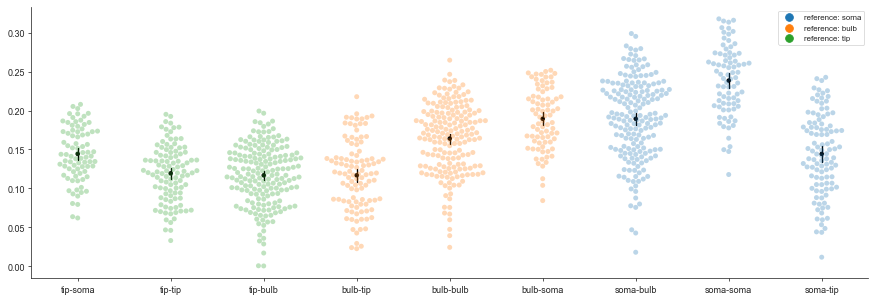

In [12]:
plt.figure(figsize=(15,5))
labels_all=np.concatenate(labels)
order = np.unique(labels_all)
order = order[np.array([7,8,6,2,0,1,3,4,5])]
reference = ['reference: '+l.split('-')[0] for l in labels_all]
means_all=np.concatenate(means)
sns.pointplot(x=labels_all,y=means_all,color='k',join=False,order=order)
ax = plt.gca()
lower = [line.get_ydata().min() for line in ax.lines]
upper = [line.get_ydata().max() for line in ax.lines]
means_plot = ax.collections[0].get_offsets()[:, 1]
print('           CONDITION   MEAN +- 95%CI')
for m,u,l,label in zip(means_plot,upper,lower,ax.get_xticklabels()):
    print(label,np.round(m,decimals=3),np.round(l,decimals=3),np.round(u,decimals=3))
sns.swarmplot(x=labels_all,y=means_all,hue=reference,alpha=0.3,order=order)
sns.despine()
plt.savefig('summary.pdf',dpi=300,bbox_inches='tight',)

Within each reference group, we tested the two [INTRA vs INTER] combinations:
e.g. [TT vs TS] and [TT vs TB], but not [TS vs TB]. All were significant, except [TT vs TB].


Between groups, we tested all three [INTRA vs INTRA] combinations
i.e. [TT vs BB], [BB vs SS], and [SS vs TT], all of which were significant.

### Slim version (excluding redundant combinations)

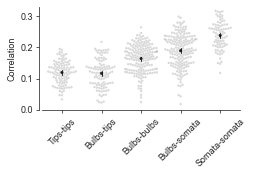

In [13]:
sns_styleset()
with matplotlib.rc_context({"lines.linewidth": 0.5}):
    plt.figure(figsize=(9/2.54,4.8/2.54))
    labels_all=np.concatenate(labels)
    include_idx = ~np.isin(labels_all,['tip-bulb','bulb-soma','soma-tip','tip-soma'])
    labels_all = labels_all[include_idx]
    order = np.unique(labels_all)
    order = order[np.array([4,1,0,2,3])]
    reference = ['reference: '+l.split('-')[0] for l in labels_all]
    means_all=np.concatenate(means)[include_idx]
    ax = sns.swarmplot(x=labels_all,y=means_all,color='tab:gray',alpha=0.3,order=order, size=2.3)
    sns.pointplot(x=labels_all,y=means_all,color='k',join=False,order=order, ax=ax)
    plt.xticks([0,1,2,3,4], labels=['Tips-tips','Bulbs-tips','Bulbs-bulbs','Bulbs-somata','Somata-somata'], rotation=45)
    plt.ylabel('Correlation')
    plt.ylim(0,0.33)
    ax.spines['left'].set_position(('outward',3))
    sns.despine()
    # plt.savefig('./figures/Fig7F_summary.svg',bbox_inches='tight',dpi=300)